In [1]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt

In [2]:
TEST_SIZE = 0.2
RANDOM_SEED = 2020
N_FOLD = 5

In [3]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

# Permutation Feature Importance for lgb

## without KFold

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# must use .fit() method for permutation_importance, so here we must use LGBMRegressor API
# LGBMRegressor is the wrapper of Training API
# see also: http://devdoc.net/bigdata/LightGBM-doc-2.2.2/_modules/lightgbm/sklearn.html
params = {
    'X': X_train,
    'y': y_train,
    'eval_set': (X_test, y_test),
    'early_stopping_rounds': 5,
    'verbose':  -1,
    'eval_metric': 'l2',
}
model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=100,
    importance_type="gain", # TODO: check split
    random_state=RANDOM_SEED
)
model.fit(**params)

importances = model.feature_importances_ # "gain"

pfi_train = permutation_importance(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring="neg_root_mean_squared_error",
    n_repeats=10,
    n_jobs=-1,
    random_state=RANDOM_SEED,
).importances_mean

pfi_test = permutation_importance(
    estimator=model,
    X=X_test,
    y=y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=10,
    n_jobs=-1,
    random_state=RANDOM_SEED,
).importances_mean

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 15.2035


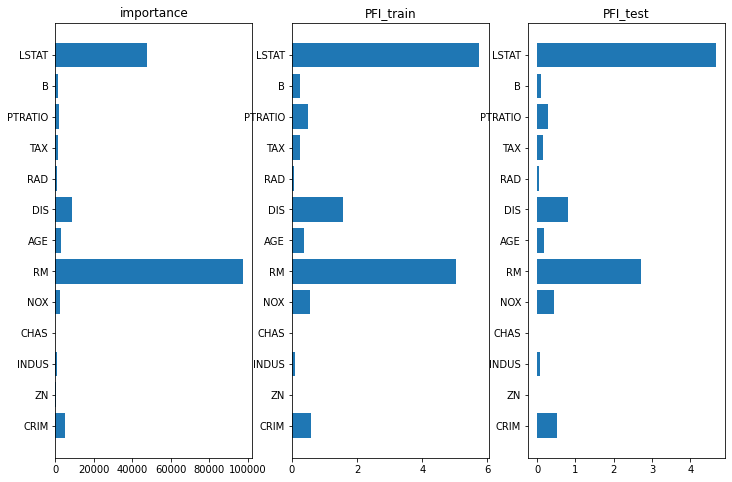

In [5]:
_, axs = plt.subplots(ncols=3, figsize=(12, 8))
for ax, title, values in zip(axs.ravel(), ["importance", "PFI_train", "PFI_test"], [importances, pfi_train, pfi_test]):
    ax.barh(width=values, y=X.columns)
    ax.set_title(f"{title}")

plt.show()

## with KFold

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 15.2035
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 12.6367
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's l2: 17.122
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 8.40795
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 8.71151


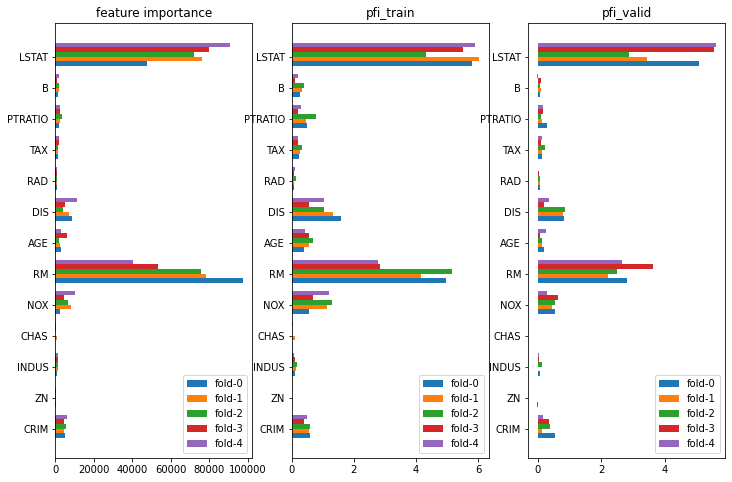

In [6]:
folds = KFold(n_splits=N_FOLD, shuffle=True, random_state=RANDOM_SEED)
fold_iter = folds.split(X, y=y)
height = 0.15
labels = X.columns
_, axs = plt.subplots(ncols=3, figsize=(12, 8))
left = np.arange(len(labels), dtype=float) - height

importance_list = []
perm_imp_list = []

for n_fold, (trn_idx, val_idx) in enumerate(fold_iter):
    X_train, X_valid = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_valid = y[trn_idx], y[val_idx]

    params = {
        'X': X_train,
        'y': y_train,
        'eval_set': (X_valid, y_valid),
        'early_stopping_rounds': 5,
        'verbose': -1,
        'eval_metric': 'l2',
    }
    model = lgb.LGBMRegressor(
        objective="regression", 
        n_estimators=100, 
        importance_type="gain",
        random_state=RANDOM_SEED,
    )
    model.fit(**params)

    importances = model.feature_importances_ # "gain"
    bar = axs[0].barh(left, importances, height=height, align='center', label=f"fold-{n_fold}")
    axs[0].bar_label(bar, label_type='center', fmt='')
    axs[0].legend()
    axs[0].set_title(f"feature importance")
    axs[0].set_yticks(left-(height*N_FOLD)/2)
    axs[0].set_yticklabels(labels)

    pfi_train = permutation_importance(
        estimator=model,
        X=X_train,
        y=y_train,
        scoring="neg_root_mean_squared_error",
        n_repeats=10,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    ).importances_mean
    bar = axs[1].barh(left, pfi_train, height=height, align='center', label=f"fold-{n_fold}")
    axs[1].bar_label(bar, label_type='center', fmt='')
    axs[1].legend()
    axs[1].set_title(f"pfi_train")
    axs[1].set_yticks(left-(height*N_FOLD)/2)
    axs[1].set_yticklabels(labels)
    
    pfi_valid = permutation_importance(
        estimator=model,
        X=X_valid,
        y=y_valid,
        scoring="neg_root_mean_squared_error",
        n_repeats=10,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    ).importances_mean
    bar = axs[2].barh(left, pfi_valid, height=height, align='center', label=f"fold-{n_fold}")
    axs[2].bar_label(bar, label_type='center', fmt='')
    axs[2].legend()
    axs[2].set_title(f"pfi_valid")
    axs[2].set_yticks(left-(height*N_FOLD)/2)
    axs[2].set_yticklabels(labels)
    
    left += height

plt.show()